In [1]:
from dataset import DataSet
from mlmodel import RNNDynamicsModel, train_RNNDynamicsModel, plot_RNNDynamicsModel_pred, dynamicsmodel_from_loader
import numpy as np
import pickle

In [ ]:
class LinearGaussianSimulator():
    def __init__(self, coupling = 0.5, b_x = 0.8, b_y = 0.4, var_x = 0.2, var_y = 0.2):
        self.coupling = coupling
        self.b_x = b_x
        self.b_y = b_y
        self.var_x = var_x
        self.var_y = var_y

    def simulate_(self, time, seed):
        """
        Simulates a stochastic coupled linear system.
        DAG: Y -> X

        hidden function, called by simulate

        returns: Y:array, X:array
        """

        N_discard = 100 # discard first 10 values

        np.random.seed(seed)
        
        # Random initialisation
        x = np.zeros((N_discard + time, ))
        y = np.zeros((N_discard + time, ))
        x[0] = np.random.normal(scale = 0.1)
        y[0] = np.random.normal(scale = 0.1)
        
        # Simulate
        for ii in range(N_discard + time - 1):
            x[ii + 1] = self.b_x * x[ii] + self.coupling * y[ii] + np.random.normal(scale = np.sqrt(self.var_x))
            y[ii + 1] = self.b_y * y[ii] + np.random.normal(scale = np.sqrt(self.var_y))
        
        return  x[N_discard:].reshape(-1, 1), y[N_discard:].reshape(-1, 1)


    def generate_dataset(self, time, seed):
        """
        Simulates a stochastic coupled linear system.
        DAG: Y -> X

        wrapper function around simulate_
        """

        X, Y = self.simulate_(time, seed)

        return DataSet({'X': X, 'Y': Y})
    
    def analytic_transfer_entropy(self):
        """
        Analytic transfer entropy for a linear system with Gaussian noise
        DAG: Y -> X

        Equation 17 in Supplementary Materials of [10.1063/5.0053519] 

        returns: float
        """
            
        var_x = self.var_x
        var_y = self.var_y
        var_x2 = var_x**2
        var_y2 = var_y**2

        b_x = self.b_x
        b_y = self.b_y
        b_x2 = b_x**2
        b_y2 = b_y**2

        lam = self.coupling

        num = ((1-b_y2)*((1-(b_x*b_y))**2)*(var_x**4)) + ((2*(lam**2))*(1-(b_x*b_y))*(var_x2)*(var_y2)) + ((lam**4)*(var_y**4))
        den = ((1-b_y2)*((1-(b_x*b_y))**2)*(var_x**4)) + ((lam**2)*((1-(b_x2*b_y2))*(var_x2)*(var_y2)))
        
        TE_Y2X = 0.5 * np.log(num/den)

        return np.round(TE_Y2X, 4)

In [ ]:
# bivar = LinearGaussianSimulator()
# dataset = bivar.generate_dataset(10000, 0)
# bivar.analytic_transfer_entropy()

In [ ]:
def downsample(time_series, factor):
    """
    Downsamples a time series by a given factor.
    """
    return time_series[::factor]

def generate_poisson_input(time_points, n_channels, mean_duration_up, mean_duration_down, seed):
    """
    Generates a binary input signal for each input channel based on a Poisson process,
    with the 'up' and 'down' states having specified mean durations.
    
    time_points: array, the time points at which the process should be sampled
    n_channels: int, number of channels to simulate
    mean_duration_up: float, mean duration for "up" state
    mean_duration_down: float, mean duration for "down" state
    sd: float, standard deviation for the duration of each state
    
    Returns: n_time_points x n_channels array of binary signals
    """
    
    # Create a local random generator
    local_rng = np.random.default_rng(seed)

    n_time_points = len(time_points)
    inputs = np.zeros((n_time_points, n_channels))
    
    # Calculate the actual time intervals between the time points
    dt = time_points[1] - time_points[0]  # Time step
    n_t = len(time_points)

    for channel in range(n_channels):
        state = 0  # Start with "down" state
        
        t = 0
        while t <= n_t:
            if state == 0:
                # Draw the duration of the "down" state from an exponential distribution
                duration = local_rng.exponential(mean_duration_up)
                # Calculate the number of corresponding time steps, and set the input to 0 until then
                t += int(np.ceil(duration/dt))
                inputs[t:, channel] = 0
                # Switch to "up" state
                state = 1
            elif state == 1:
                # Draw the duration of the "up" state from an exponential distribution
                duration = local_rng.exponential(mean_duration_down)
                # Calculate the number of corresponding time steps, and set the input to 1 until then
                t += int(np.ceil(duration/dt))
                inputs[t:, channel] = 1
                # Switch to "down" state
                state = 0
            
    return inputs

def simulate_neural_dynamics(time_points, n_neurons, input_signals, sigma, A, C, random_neural_activity):
    """
    Simulates neural dynamics based on the given differential equation model.

    time_points: array, the time points at which the process should be sampled
    n_neurons: int, number of neurons in the system
    input_signals: array, the input binary signals for each channel
    sigma: float, the rate of change of the system
    A: matrix, the connectivity matrix A
    C: matrix, the matrix of external inputs

    Returns: an array of neural time series of equal size to input_signals
    """
    
    dt = time_points[1] - time_points[0]  # Time step

    # Initialize the output array with the required dimensions
    neural_dynamics = np.zeros((input_signals.shape[0], n_neurons))

    z = np.zeros_like(neural_dynamics[0])  # Initial state of neural time series
    
    # Euler method to solve the differential equation
    for i in range(1, len(input_signals)):
        # Update the neural time series based on the rate of change
        z_dot = sigma * A@z + C@input_signals[i - 1]
        z_dot *= dt
        z = z + z_dot
        if random_neural_activity > 0:
            np.random.seed(i)
            z += np.random.normal(0, random_neural_activity, size=z.shape)

        neural_dynamics[i] = z
    
    return neural_dynamics

def bold_equation(time_points, neural_activity):
    """
    Given neural activity, returns the BOLD signal.
    Based on the work of Stephan et al. (2007) [10.1016/j.neuroimage.2007.07.040] and Maith et al. (2022) [10.3389/fninf.2022.790966]
    
    time_points: array, the time points at which the BOLD signal should be calculated
    neural_activity: array, the neural activity

    Returns: an array of BOLD signal values
    """
    
    # Get time step
    dt = time_points[1] - time_points[0]
    if dt > 0.11:
        raise ValueError("The time step is too large. This will result in instability for the Forward Euler method.")

    # Parameters
    kappa     = 1/1.54  # signal decay
    gamma     = 1/2.46  # feedback regulation
    E_0       = 0.34    # oxygen extraction fraction at rest
    tau       = 0.98    # time constant
    alpha     = 0.33    # vessel stiffness
    V_0       = 0.02    # resting venous blood volume fraction
    v_0       = 40.3    # frequency offset at the outer surface of the magnetized vessel for fully deoxygenated blood at 1.5 T
    TE        = 40*dt   # echo time
    epsilon   = 1.43    # ratio of intra- and extravascular signal

    # Coefficients
    k_1 = (1-V_0) * 4.3 * v_0 * E_0 * TE
    k_2 = 2 * E_0
    k_3 = 1 - epsilon

    # Vasodilatory signal
    def ds_dt(x, s, f_in):
        return (x - kappa*s - gamma*(f_in - 1))

    # Flow in
    def flow_in(s):
        return s
    
    # Flow out
    def flow_out(v):
        return v**(1/alpha)
    
    # Changes in volume
    def dv_dt(f_in, v):
        return (f_in - flow_out(v)) / tau

    # Oxigen extraction fraction
    def extract(f_in):
        return (1-(1-E_0)**(1/f_in))

    # Change in deoxyhemoglobin
    def dq_dt(f_in, q, v):
        return (f_in*(extract(f_in)/E_0) - flow_out(v)*(q/v)) / tau                                       

    # BOLD signal change equation
    def BOLD(q, v):
        return V_0 * (k_1*(1-q) + k_2*(1-(q/v)) + k_3*(1-v))

    
    # Initialize arrays
    s = np.zeros(len(time_points));         s[0] = 0
    f_in = np.zeros(len(time_points));      f_in[0] = 1
    v = np.zeros(len(time_points));         v[0] = 1
    e = np.zeros(len(time_points));         e[0] = 0.34
    q = np.zeros(len(time_points));         q[0] = 1
    bold = np.zeros(len(time_points))

    for t in range(1, len(time_points)):
        # Get previous values
        s_t = s[t-1]
        f_t = f_in[t-1]
        v_t = v[t-1]
        q_t = q[t-1]

        # Get current values
        s_t1 = s_t + dt * ds_dt(neural_activity[t], s_t, f_t)
        f_t1 = f_t + dt * flow_in(s_t)
        v_t1 = v_t + dt * dv_dt(f_t, v_t)
        e_t1 = extract(f_t)
        q_t1 = q_t + dt * dq_dt(f_t, q_t, v_t)

        # Save current values
        s[t] = s_t1
        f_in[t] = f_t1
        v[t] = v_t1
        e[t] = e_t1
        q[t] = q_t1

        # Calculate BOLD signal
        bold[t] = BOLD(q_t1, v_t1)

    return bold

def simulate_bold_signal(time_points, neural_activity):
    """
    Simulates the BOLD signal given neural activity.
    
    wrapper for bold_equation(), executes the equation for each channel in the neural activity
    """
    
    bold = np.zeros_like(neural_activity)
    for i in range(neural_activity.shape[1]):
        bold[:, i] = bold_equation(time_points, neural_activity[:, i])

    return bold



class NeuralSimulator():
    def __init__(
            self, 
            n_inputs:int, 
            n_neurons:int, 
            A:np.ndarray, 
            C:np.ndarray,
            mean_duration_up:float=2.5,
            mean_duration_down:float=10.0,
            sigma:float=1.0,
            samplerate:int=1,
            random_neural_activity:float=0.0,
            random_bold_error:float=0.0
            ):
        
        """
        Initializes a neural simulator.
        
        n_inputs:    int, number of input channels
        n_neurons:  int, number of neurons in the system
        A: matrix,  the connectivity matrix A
        C: matrix,  the matrix of external inputs
        mean_duration_up: float, mean duration for "up" state
        mean_duration_down: float, mean duration for "down" state
        sigma: float, the rate of change of the system
        samplerate: int, the rate at which to sample the BOLD signal
        random_neural_activity: float, the amount of random noise to add to the neural activity
        random_bold_error: float, the amount of random noise to add to the BOLD signal
        """
        
        if n_inputs <= 0:
            raise ValueError("The number of input channels must be greater than 0.")
        self.n_inputs = n_inputs

        if n_neurons <= 0:
            raise ValueError("The number of neurons must be greater than 0.")
        self.n_neurons = n_neurons

        if A.shape != (n_neurons, n_neurons):
            raise ValueError(f"The dimensions of the connectivity matrix A do not match the number of neurons (should be {n_neurons}x{n_neurons}).")
        # eigenvalues = np.linalg.eigvals(A)
        # magnitudes = np.abs(eigenvalues)
        # if np.any(magnitudes >= 1):
        #     raise ValueError("The absolute value of all eigenvalues of the connectivity matrix A must be less than 1 for the system to be stable.")
        self.A = A
        
        if C.shape != (n_neurons, n_inputs):
            raise ValueError(f"The dimensions of the input matrix C do not match the number of neurons and input channels (should be {n_neurons}x{n_inputs})")
        self.C = C

        if mean_duration_up <= 0:
            raise ValueError("The mean duration of the 'up' state must be greater than 0.")
        self.mean_duration_up = mean_duration_up

        if mean_duration_down <= 0:
            raise ValueError("The mean duration of the 'down' state must be greater than 0.")
        self.mean_duration_down = mean_duration_down

        if sigma <= 0:
            raise ValueError("The rate of change of the system must be greater than 0.")
        self.sigma = sigma

        if samplerate not in [1, 2, 5, 10]:
            raise ValueError("The samplerate must be one of 1, 2, 5 or 10.")
        self.samplerate = samplerate

        if random_neural_activity < 0 or random_neural_activity > 1:
            raise ValueError("random_neural_activity must be a float between 0 and 1.")
        self.random_neural_activity = random_neural_activity

        if random_bold_error < 0 or random_bold_error > 1:
            raise ValueError("random_neural_activity must be a float between 0 and 1.")
        self.random_bold_error = random_bold_error

    def simulate_(self, time, seed):
        """
        Simulates input, resulting neural activity and resulting BOLD signal.
        DAG: input -> neural activity -> BOLD signal
        
        hidden function, which returns all variables. Normallt called by simulate(), which then selects variables
        
        time: duration of the simulation in seconds
        seed: int, the seed for the random number generator

        returns: input_signals: array, neural_activity: array, bold_signal:array
        """

        SAMPLERATE = 10  # Hz
        DOWNSAMPLE = int(SAMPLERATE/self.samplerate)

        time_points = np.linspace(0, time, int(time*SAMPLERATE)+1)

        # Generate input signals
        input_signals   = generate_poisson_input(time_points, self.n_inputs, self.mean_duration_up, self.mean_duration_down, seed)
        
        # Simulate neural dynamics
        neural_activity = simulate_neural_dynamics(time_points, self.n_neurons, input_signals, self.sigma, self.A, self.C, self.random_neural_activity)
        
        # Simulate BOLD signal
        bold_signal     = simulate_bold_signal(time_points, neural_activity)

        # Downsample to 1 Hz
        input_signals   = downsample(input_signals,  DOWNSAMPLE)
        neural_activity = downsample(neural_activity, DOWNSAMPLE)
        bold_signal     = downsample(bold_signal,  DOWNSAMPLE)
        
        # Add random noise to the BOLD signal
        if self.random_bold_error > 0:
            np.random.seed(1)
            bold_signal += np.random.normal(0, self.random_bold_error, size=bold_signal.shape)

        return input_signals, neural_activity, bold_signal
    
    def simulate(self, time, seed):
        """
        Simulates input, resulting neural activity and resulting BOLD signal.
        DAG: input -> neural activity -> BOLD signal

        wrapper for simulate_(), returns only the specified variables

        time: duration of the simulation in seconds
        seed: int, the seed for the random number generator
        var_cause: str, the variable to use as the cause
        var_outcome: str, the variable to use as the outcome
        """

    
        
        # Call simulate_() to get all variables
        input_signal, neural_activity, bold_signal = self.simulate_(time, seed)

        return DataSet({'input_signal': [input_signal], 'neural_activity': [neural_activity], 'bold_signal': [bold_signal]})


In [ ]:
# Small system
n_inputs = 3  # number of input channels
n_neurons = 3 # number of neurons

# Example connectivity matrix
A = np.array([
    [-1, 0.2, 0.1], 
    [0.5, -1, 0.0], 
    [0.1, 0.1, -1]
    ])
# Example transfer matrix
C = np.array([
    [1, 0, 0.1], 
    [0, 0.1, 1],
    [0.1, 1, 0.3]
    ])

neural_simulator = NeuralSimulator(n_inputs, n_neurons, A, C)
dataset = neural_simulator.simulate(20000, 0)

In [ ]:
import torch; torch.set_printoptions(sci_mode=None)
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [ ]:
dataloader_1, dataloader_2 = dataset.get_TE_dataloaders('input_signal', 'bold_signal',device)

Epoch [500/500], Loss: -2.3440799713134766          


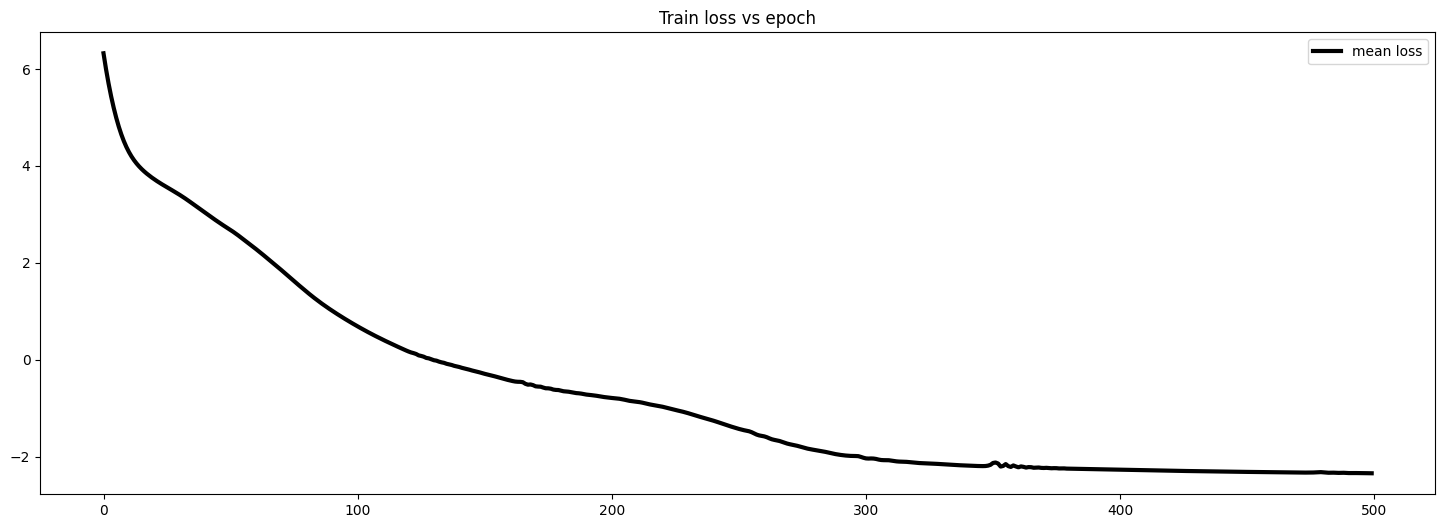

NameError: name 'features_to' is not defined

In [ ]:
model_1 = dynamicsmodel_from_loader(dataloader_1, rnn_type='GRU', model_type='gaussian', hidden_size=5, num_layers=1, device=device)

model_1, loss_1 = train_RNNDynamicsModel(model_1, dataloader_1, epochs=500, learning_rate=0.01, plot=True)  
plot_RNNDynamicsModel_pred(model_1, dataloader_1[0][0], dataloader_1[1][0], 0, plot_end=300, by_dim=True)

model_2 = dynamicsmodel_from_loader(dataloader_2, rnn_type='GRU', model_type='gaussian', hidden_size=5, num_layers=1, device=device)

model_2, loss_2 = train_RNNDynamicsModel(model_2, dataloader_2, epochs=500, learning_rate=0.01, plot=True)
plot_RNNDynamicsModel_pred(model_2, dataloader_2[0][0], dataloader_2[1][0], 0, plot_end=300, by_dim=True)

print(round(loss_1 - loss_2, 4))